In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.optim import lr_scheduler
import torch.utils.data
import torchvision.transforms as transforms


In [84]:
#Utils
def display3DObject(test_object):   
    print("Displaying the object")
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(test_object, edgecolor='k')
    plt.show()
    
def addNoise(shape, noise=0.1):
    #print(shape)
    return Variable(torch.zeros(shape).normal_(0, noise).cuda())

In [85]:
# Creating a generator: Image to 3D voxel space 
# torch.nn.ConvTranspose3d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1)
# (Din−1)∗stride[0]−2∗padding[0]+kernel_size[0]+output_padding[0]

# Latent to 3D Space
class decoder(nn.Module):
    def __init__(self, z_size=200, cube_size=32):
        super(decoder, self).__init__()
        
        self.z_size = z_size
        self.cube_size = cube_size
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.z_size, self.cube_size*4, kernel_size=4, stride=2, padding=(0,0,0)),
            torch.nn.BatchNorm3d(self.cube_size*4),
            torch.nn.ReLU()
        )
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*4, self.cube_size*2, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*2),
            torch.nn.ReLU()
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*2, self.cube_size*1, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*1),
            torch.nn.ReLU()
        )

        self.layer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size, 1, kernel_size=4, stride=2,  padding=(1, 1, 1)),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        return out
class encoder(nn.Module):
    def __init__(self, input_nc=1, output_nc=200, ndf=25):
        super(encoder, self).__init__()
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf),
            torch.nn.ReLU()
        )
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*2),
            torch.nn.ReLU()
        )
        
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*4),
            torch.nn.ReLU()
        )
        
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=4, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.layer6 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.Tanh()
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        return out
    
# class encoder(nn.Module):
#     def __init__(self, input_nc=1, output_nc=200, ngf=8, norm_layer=nn.BatchNorm2d,\
#                  use_dropout=False, padding_type='reflect'):
#         super(encoder, self).__init__()
#         self.input_nc = input_nc
#         self.output_nc = output_nc
#         self.ngf = ngf
        
#         use_bias = norm_layer == nn.InstanceNorm2d

#         model = [nn.ReflectionPad2d(2),
#                  nn.Conv2d(input_nc, ngf, kernel_size=5, padding=0,
#                            bias=use_bias),
#                  norm_layer(ngf),
#                  nn.ReLU(True)]
        
        
#         n_downsampling = 4
#         for i in range(n_downsampling):
#             mult = 2**i
#             model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=5,
#                                 stride=2, padding=1, bias=use_bias),
#                       norm_layer(ngf * mult * 2),
#                       nn.ReLU(True)]
        
#         for i in range(2):
#             model += [nn.Conv2d(ngf * mult * 2, ngf * mult * 2, kernel_size=3,
#                                     stride=2, padding=1, bias=use_bias),
#                           norm_layer(ngf * mult * 2),
#                           nn.ReLU(True)]
            
#         model += [nn.Conv2d(ngf * mult * 2, output_nc, kernel_size=2,
#                                     stride=1, padding=0, bias=use_bias)]
#         model += [nn.Tanh()]
        
            
        

# #         mult = 2**(n_downsampling-1)
# #         for i in range(n_blocks):
# #             model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer,\
# #                                   use_dropout=use_dropout, use_bias=use_bias)]
            
#         self.model = nn.ModuleList(model)
# #         self.model = nn.Sequential(*model)

#     def forward(self, x):
#         for model in self.model:
#             x = model(x)
# #             print(x.size())
#         return x
#         #return self.model(input)
        
        

In [86]:
# Conv3d: (in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
# input size (N,Cin,D,H,W) and output (N,Cout,Dout,Hout,Wout) 


class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.cube_len = 32
        self.leak_value = 0.2
        self.bias = False

        padd = (0,0,0)
        if self.cube_len == 32:
            padd = (1,1,1)
            
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv3d(1, self.cube_len, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len, self.cube_len*2, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*2),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*2, self.cube_len*4, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*4),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*4, self.cube_len*8, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*8),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*8, 1, kernel_size=4, stride=2, bias=self.bias, padding=padd),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        #print(x)
        out = x.view(-1, 1, self.cube_len, self.cube_len, self.cube_len)
#         print(out.size()) # torch.Size([100, 1, 32, 32, 32])
        out = self.layer1(out)
#         print(out.size())  # torch.Size([100, 32, 16, 16, 16])
        out = self.layer2(out)
#         print(out.size())  # torch.Size([100, 64, 8, 8, 8])
        out = self.layer3(out)
#         print(out.size())  # torch.Size([100, 128, 4, 4, 4])
        out = self.layer4(out)
#         print(out.size())  # torch.Size([100, 256, 2, 2, 2])
        out = self.layer5(out)
#         print(out.size())  # torch.Size([100, 1, 1, 1, 1])

        return out.squeeze()
        

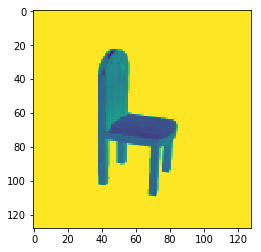

In [109]:
# load data
# images = np.load('padded_gray_chair_imgs.npy')
# print(images.shape)
# pil_format =Variable(torch.FloatTensor(images)).view(128,128, -1)
# pil_format.shape
# pil_format = pil_format.data.numpy()
# print(pil_format.shape)
# image_tensor_format = transforms.ToTensor()
# normalize = transforms.Normalize((0, ), (1, ))
# normalized_images = normalize(image_tensor_format(pil_format))
# print(normalized_images.shape)
images = np.load('padded_gray_chair_imgs.npy')
#images[:] *= 1/images[:].max() 
images[:] = 2*(images[:] - np.max(images[:]))/-np.ptp(images[:])-1
#images[:] = (images[:] - np.mean(images[:])) / np.std(images[:])
batch_size = 20
train_data = [np.load('chair_voxels.npy'), images]
for _ in range(len(train_data)):
    train_data[_] =torch.from_numpy(train_data[_]).type(torch.FloatTensor)
    train_data[_] = train_data[_].cuda()
train_data = [(train_data[0][i], train_data[1][i]) for i in range(len(train_data[0]))] 
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, drop_last=True)
plt.imshow(images[1])

In [110]:

lr_g = 0.0025
lr_d = 0.001
adam_beta_g = (0, 0)
adam_beta_d = (0, 0)

In [111]:
enc = encoder()
enc.cuda()
dec = decoder()
dec.cuda()
dis3d = discriminator()
dis3d.cuda()
print(enc)

encoder(
  (layer1): Sequential(
    (0): Conv2d(1, 25, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(100, 200, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(200, 200, kernel_size=(4, 4), stride=(4, 4), padding=(1, 1))
    (1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
  )
  (layer6): Sequential(
    (0): Conv2d(200, 200, kernel_size=(4, 4), stri

In [112]:

# D_solver = optim.RMSprop(dis3d.parameters(), lr=lr_d)
# Encoder_solver = optim.RMSprop(enc.parameters(), lr=lr_g)
# Decoder_solver = optim.RMSprop(dec.parameters(), lr=lr_g)
D_solver = optim.Adam(dis3d.parameters(), lr=lr_d, betas = adam_beta_d)
Encoder_solver = optim.Adam(enc.parameters(), lr=lr_g, betas = adam_beta_g)
Decoder_solver = optim.Adam(dec.parameters(), lr=lr_g, betas = adam_beta_g)

In [113]:
G_Losses = []
D_Losses = []
R_Accs = []
F_Accs = []

In [114]:
#Training the system
num_epochs = 20

loss = nn.BCELoss()

for epoch in range(num_epochs):
    d_losses = []
    g_losses = []
    real_accs = []
    fake_accs = []
    for batch_idx, (data3d, data2d) in enumerate(train_loader):
        real_labels = Variable(torch.ones(batch_size).cuda())
        fake_labels = Variable(torch.zeros(batch_size).cuda())
        real = Variable(data3d).cuda().float()
        data2d = data2d.unsqueeze(1)
        shape = list(data2d.size())
        fake_2d = Variable(data2d).cuda().float() + addNoise(shape)
        #Discriminator loss
        #z = generateLatent(batch_size=batch_size)
        encoded_z = enc(fake_2d).unsqueeze(4)
        fake = dec(encoded_z)
        fake_labels_pred = dis3d(fake)
        #print(Variable(data3d))
        real_labels_pred = dis3d(real)
        #print(real_labels_pred)
        loss_fake = loss(fake_labels_pred, fake_labels)
        loss_real = loss(real_labels_pred, real_labels)
        d_loss = loss_fake + loss_real
        d_real_acu = torch.ge(real_labels_pred.squeeze(), 0.5).float()
        d_fake_acu = torch.le(fake_labels_pred.squeeze(), 0.5).float()
        d_real_acu_mean = torch.mean(d_real_acu)
        d_fake_acu_mean = torch.mean(d_fake_acu)
        d_total_acu = torch.mean(torch.cat((d_real_acu, d_fake_acu),0))
        if d_total_acu.data.cpu().numpy() <=0.8:
#         print(d_total_acu.data)
#         if d_total_acu <= 0.8:
            dis3d.zero_grad()
            d_loss.backward()
            D_solver.step()
        
        #Generator loss 
        fake_2d = Variable(data2d).cuda().float() + addNoise(shape)
        encoded_z = enc(fake_2d).unsqueeze(4) 
        fake = dec(encoded_z)
        d_fake = dis3d(fake)
        g_loss = loss(d_fake, real_labels)

        dis3d.zero_grad()
        enc.zero_grad()
        dec.zero_grad()
        g_loss.backward()
        Decoder_solver.step()
        Encoder_solver.step()
        
        d_losses.append(d_loss.data.cpu().numpy())
        g_losses.append(g_loss.data.cpu().numpy())
        real_accs.append(d_real_acu_mean.data.cpu().numpy())
        fake_accs.append(d_fake_acu_mean.data.cpu().numpy())
        
#         #Printing
#         if batch_idx%50 == 0:
#             print("Epoch: ", epoch)
#             print("batch iteration: ", batch_idx, "D loss: ", d_loss.data.cpu().numpy(), \
#                   " G loss: ", g_loss.data.cpu().numpy())
#             print("Accuracy: ", d_total_acu.data.cpu().numpy(), " Real Acc: ", d_real_acu_mean.data.cpu().numpy(), \
#                   " Fake Acc: ", d_fake_acu_mean.data.cpu().numpy())
        
    d_losses_mean = np.mean(np.concatenate(d_losses))
    g_losses_mean =  np.mean(np.concatenate(g_losses))
    real_accs_mean =  np.mean(np.concatenate(real_accs))
    fake_accs_mean =  np.mean(np.concatenate(fake_accs))
    
    print("Epoch: ", epoch, '\n', "D loss: ", d_losses_mean, " G loss: ", g_losses_mean)
    print(" Accuracy: ", (real_accs_mean+ fake_accs_mean)/2 , " Real Acc: ", real_accs_mean, \
          " Fake Acc: ", fake_accs_mean)
    
    G_Losses.append(g_losses_mean)
    D_Losses.append(d_losses_mean)
    R_Accs.append(real_accs_mean)
    F_Accs.append(fake_accs_mean)

Epoch:  0 
 D loss:  0.87981635  G loss:  1.800501
 Accuracy:  0.8189284801483154  Real Acc:  0.8549999  Fake Acc:  0.7828571
Epoch:  1 
 D loss:  1.216135  G loss:  1.1956191
 Accuracy:  0.7282142639160156  Real Acc:  0.83214283  Fake Acc:  0.6242857
Epoch:  2 
 D loss:  1.4129996  G loss:  1.2444508
 Accuracy:  0.5603571534156799  Real Acc:  0.63357145  Fake Acc:  0.48714283
Epoch:  3 
 D loss:  1.4034086  G loss:  1.1885667
 Accuracy:  0.54964280128479  Real Acc:  0.5828571  Fake Acc:  0.5164285
Epoch:  4 
 D loss:  1.3705045  G loss:  1.1993008
 Accuracy:  0.5685714483261108  Real Acc:  0.60999995  Fake Acc:  0.5271429
Epoch:  5 
 D loss:  1.320877  G loss:  1.3761085
 Accuracy:  0.6032143235206604  Real Acc:  0.65142864  Fake Acc:  0.555
Epoch:  6 
 D loss:  1.2799658  G loss:  1.5377318
 Accuracy:  0.6064285635948181  Real Acc:  0.65999997  Fake Acc:  0.55285716
Epoch:  7 
 D loss:  1.2472574  G loss:  1.6088581
 Accuracy:  0.6410714387893677  Real Acc:  0.66142863  Fake Acc:  0.

KeyboardInterrupt: 

Displaying the object


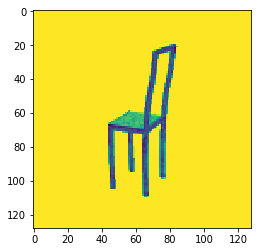

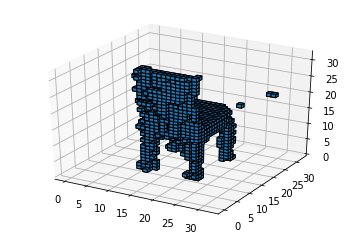

Displaying the object


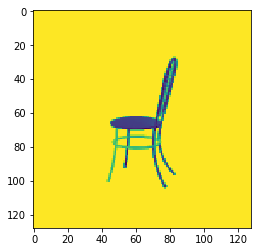

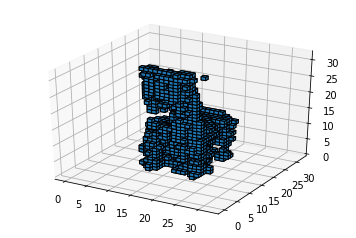

Displaying the object


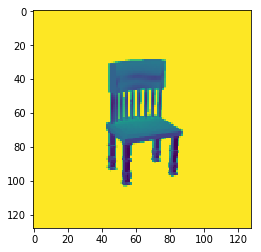

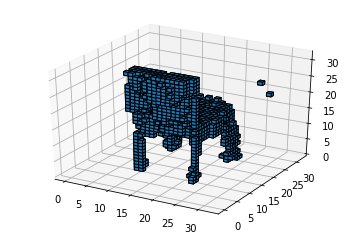

Displaying the object


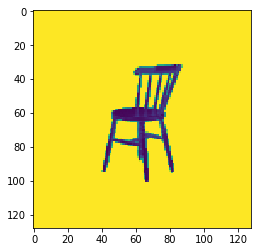

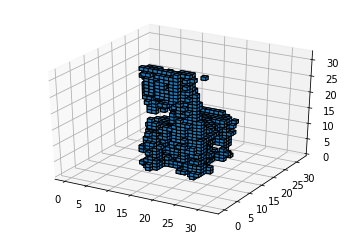

Displaying the object


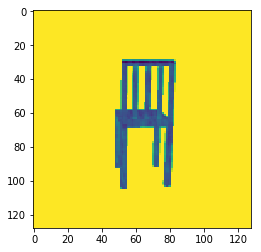

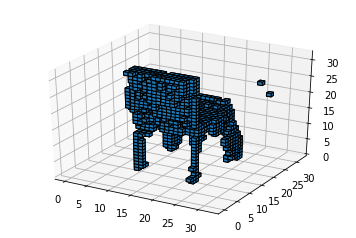

Displaying the object


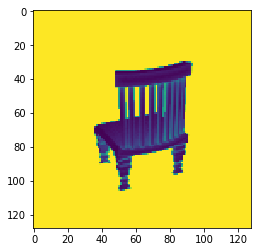

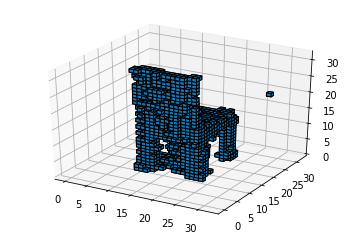

In [117]:
# test
import random
for j in range(43,49):
    i = random.randint(1,100)
    test_image = Variable(torch.FloatTensor(images[i]).cuda()).view(-1,1,128,128) + addNoise([1,1,128,128])
    plt.imshow(images[i])
    latent = enc(test_image)
    faker = dec(latent.unsqueeze(4))
    display3DObject(faker.squeeze().data.cpu().numpy()>0.5)

In [ ]:
# images = np.load("padded_gray_chair_imgs.npy")
# print(images[0:1].shape)

In [ ]:
enc = encoder()
test_image = Variable(torch.FloatTensor(images[0:2])).view(-1,1,128,128)
value = enc(test_image)
print(value.unsqueeze(4).shape)
dec = decoder()
value = dec(value.unsqueeze(4))
print(value.shape)

In [ ]:


# test_image = Variable(torch.FloatTensor(images[i]).cuda()).view(-1,1,128,128)
# print(list(test_image.size()))
# print(addNoise(list(test_image.size())))
# test_image = Variable(torch.FloatTensor(images[i]).cuda()).view(-1,1,128,128)
# print(torch.FloatTensor(images[i]).unsqueeze(-1).shape)
# u = transforms.ToTensor()
# m = transforms.Normalize((0.5, ), (0.5, ))
# value = m(u(images[0:1]))
# print(value.shape)
images = np.load('padded_gray_chair_imgs.npy')
print(images.shape)
abcd = images[1]
# print(abcd.shape)
# print(abcd[64,:])
# print(abcd.max())
# images[:] *= 1/images[:].max()
print(np.ptp(images[1]))
#images[:] = 2*(images[:] - np.max(images[:]))/-np.ptp(images[:])-1
images[:] = (images[:] - np.mean(images[:])) / np.std(images[:])
plt.imshow(images[4])
# print(abcd[64,:])
print(images[4].max())
print(images[4,66,:])
# pil_format =Variable(torch.FloatTensor(images)).view(128,128, -1)
# pil_format.shape
# pil_format = pil_format.data.numpy()
# print(pil_format.shape)
# image_tensor_format = transforms.ToTensor()
# normalize = transforms.Normalize((0.5, ), (0.5, ))
# normalized_images = normalize(image_tensor_format(pil_format))
# print(normalized_images)
# plt.imshow(images[i])

In [ ]:
class encoder(nn.Module):
    def __init__(self, input_nc=1, output_nc=200, ndf=25):
        super(encoder, self).__init__()
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf),
            torch.nn.ReLU()
        )
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*2),
            torch.nn.ReLU()
        )
        
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*4),
            torch.nn.ReLU()
        )
        
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=4, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.layer6 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.Tanh()
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        return out

In [ ]:
ec = encoder()
abcd = Variable(torch.FloatTensor(images[1])).view(-1,1,128,128)
print(abcd.shape)
ec(abcd).shape

In [ ]:
import random
random.randint(1,100)